In [1]:
! pip install -Uq fastai fastcore fastkaggle kaggle pynvml timm==0.6.2.dev0

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
from fastkaggle import *
from fastcore.parallel import *
from fastai.vision.all import *

In [6]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm==0.6.2.dev0"')


# trn_path = path / 'train_images'

In [55]:
trn_path = path/'sml'

In [8]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

In [9]:
df = pd.read_csv(path / 'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [10]:
df.loc['100330.jpg', 'variety']

'ADT45'

In [11]:
def get_variety(p): return df.loc[p.name, 'variety']

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(0.2),
    item_tfms=Resize(192, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=128, min_scale=0.75),
).dataloaders(trn_path)

In [ ]:
dls.show_batch(max_n=6)

In [12]:
def disease_loss(inp, disease, variety): return F.cross_entropy(inp[:, :10], disease)
def variety_loss(inp, disease, variety): return F.cross_entropy(inp[:, 10:], variety)
def overall_loss(inp, disease, variety): return disease_loss(inp, disease, variety) + variety_loss(inp, disease, variety)
def disease_err(inp, disease, variety): return error_rate(inp[:,:10], disease)
def variety_err(inp, disease, variety): return error_rate(inp[:,10:], variety)

err_metrics = (disease_err, variety_err)
all_metrics = err_metrics + (disease_loss, variety_loss)

def train_mult(arch,
               item=Resize(192, method=ResizeMethod.Squish),
               batch=aug_transforms(size=128, min_scale=0.75),
               epochs=5, lr=0.01):
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock, CategoryBlock),
        n_inp=1,
        get_items=get_image_files,
        get_y=[parent_label, get_variety],
        splitter=RandomSplitter(0.2),
        item_tfms=item,
        batch_tfms=batch,
    ).dataloaders(trn_path)

    learn = vision_learner(dls, arch, n_out=20, loss_func=overall_loss, metrics=all_metrics).to_fp16()
    learn.fine_tune(epochs, lr)
    return learn

In [14]:
learn = train_mult('resnet26d', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.198171,2.121244,0.473811,0.212878,1.456847,0.664397,00:10


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.004896,1.437106,0.338779,0.156175,0.989374,0.447732,00:11
1,1.534201,0.997659,0.231619,0.103316,0.684890,0.312769,00:11
2,1.138111,0.668754,0.150889,0.068717,0.481233,0.187520,00:11
3,0.861547,0.531547,0.128304,0.049495,0.384471,0.147076,00:11
4,0.692086,0.502793,0.118693,0.048534,0.366629,0.136164,00:11


In [15]:
learn = train_mult('convnext_small_in22k', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.374121,1.141770,0.246997,0.125901,0.757079,0.384691,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.177036,0.648369,0.139837,0.068717,0.445373,0.202996,00:20
1,0.890303,0.466152,0.105238,0.047573,0.320053,0.146099,00:20
2,0.583878,0.324066,0.083614,0.022105,0.258381,0.065686,00:21
3,0.356082,0.208802,0.051898,0.012494,0.166952,0.041851,00:21
4,0.269124,0.197910,0.049976,0.011533,0.159003,0.038907,00:21


In [16]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.309283,1.231965,0.254685,0.130706,0.809533,0.422432,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.059927,0.669186,0.158097,0.055262,0.486196,0.182991,00:21
1,0.819467,0.469493,0.104277,0.052379,0.319473,0.150020,00:21
2,0.521317,0.296040,0.075925,0.026430,0.214086,0.081954,00:21
3,0.312097,0.214177,0.049015,0.014416,0.163908,0.050270,00:21
4,0.214902,0.192200,0.051418,0.012494,0.149103,0.043097,00:21


In [43]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)

In [46]:
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0399)

In [56]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=12, lr=0.05)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.454495,1.282942,0.263815,0.146084,0.803236,0.479706,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.876098,0.576787,0.147045,0.049015,0.428618,0.148168,00:21
1,0.771991,0.526897,0.120135,0.045651,0.393779,0.133117,00:21
2,0.846310,0.535799,0.118693,0.043248,0.404225,0.131574,00:21
3,0.713606,0.583141,0.123498,0.064392,0.411277,0.171865,00:21
4,0.509220,0.441050,0.084575,0.025949,0.346051,0.094999,00:21
5,0.440470,0.421923,0.083614,0.027871,0.338387,0.083535,00:21
6,0.308867,0.348068,0.055262,0.044690,0.220719,0.127349,00:21
7,0.177146,0.215404,0.040365,0.011533,0.170071,0.045332,00:21
8,0.124725,0.184640,0.032677,0.006247,0.158400,0.026240,00:21
9,0.088942,0.184183,0.031716,0.005766,0.158082,0.026101,00:21


In [48]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0288)

In [57]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=16, lr=0.05)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.481592,1.368520,0.263815,0.168188,0.819950,0.548571,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.919651,0.640784,0.152811,0.054781,0.465354,0.175430,00:21
1,0.689989,0.631843,0.127343,0.056223,0.425673,0.206170,00:21
2,0.741369,0.548382,0.109563,0.057665,0.361648,0.186734,00:21
3,0.670034,0.625307,0.100913,0.068236,0.356377,0.268930,00:21
4,0.671393,0.647018,0.114849,0.046132,0.468465,0.178553,00:21
5,0.510468,0.513812,0.091302,0.047573,0.313296,0.200516,00:21
6,0.454402,0.262291,0.048534,0.026430,0.182751,0.079540,00:21
7,0.369885,0.263096,0.042768,0.017299,0.177412,0.085685,00:21
8,0.300680,0.250080,0.043248,0.019222,0.165453,0.084627,00:21
9,0.202481,0.209054,0.038924,0.013455,0.146238,0.062816,00:21


In [58]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0235)

In [66]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=16, lr=5e-4)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,4.577718,2.355789,0.340702,0.324363,1.060234,1.295555,00:16


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.314523,2.093600,0.303220,0.281595,0.943422,1.150178,00:21
1,2.878628,1.767328,0.264296,0.219125,0.833361,0.933967,00:21
2,2.398186,1.408586,0.222009,0.161461,0.712417,0.696170,00:21
3,1.931923,1.073153,0.194618,0.111485,0.599385,0.473768,00:21
4,1.543659,0.862253,0.149928,0.088419,0.502695,0.359559,00:21
5,1.263238,0.715658,0.137914,0.068717,0.449118,0.266540,00:21
6,1.048310,0.608697,0.124459,0.063431,0.393064,0.215633,00:21
7,0.931829,0.556393,0.103796,0.055262,0.364037,0.192356,00:21
8,0.859989,0.488980,0.093705,0.047093,0.326630,0.162349,00:21
9,0.765713,0.450339,0.095147,0.042768,0.308104,0.142235,00:21


In [67]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0654)

In [68]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=16, lr=1e-3)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.962033,1.843152,0.288803,0.239308,0.865938,0.977214,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.429832,1.394634,0.244594,0.156175,0.716804,0.677830,00:21
1,2.044289,1.064543,0.188852,0.118212,0.588057,0.476486,00:21
2,1.572681,0.799125,0.161941,0.076886,0.500286,0.298839,00:21
3,1.196739,0.615965,0.132148,0.060548,0.402318,0.213647,00:21
4,0.980479,0.510409,0.113407,0.041326,0.358473,0.151936,00:21
5,0.795201,0.421792,0.101874,0.037482,0.308016,0.113776,00:21
6,0.674662,0.358700,0.086016,0.028832,0.262748,0.095952,00:21
7,0.604163,0.314924,0.073042,0.026430,0.232256,0.082667,00:21
8,0.530215,0.280155,0.068717,0.019702,0.212753,0.067402,00:21
9,0.458826,0.251857,0.061509,0.016338,0.193361,0.058497,00:21


In [69]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0461)

In [70]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=24, lr=1e-3)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.854812,1.780372,0.302739,0.209034,0.930031,0.850340,00:15


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.432223,1.493997,0.256607,0.168669,0.782548,0.711449,00:21
1,2.082455,1.211468,0.215281,0.123498,0.675602,0.535866,00:21
2,1.705047,0.969989,0.175877,0.096588,0.572456,0.397533,00:21
3,1.370126,0.780604,0.149928,0.083133,0.480733,0.299871,00:21
4,1.085103,0.646949,0.125901,0.064873,0.419885,0.227064,00:21
5,0.872348,0.533792,0.110524,0.057665,0.354765,0.179027,00:21
6,0.781596,0.470501,0.098030,0.048054,0.312594,0.157907,00:21
7,0.641501,0.405453,0.087938,0.043248,0.281310,0.124143,00:21
8,0.573558,0.347444,0.077367,0.035560,0.242024,0.105420,00:21
9,0.493325,0.300661,0.062470,0.031235,0.203217,0.097444,00:21


In [71]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0360)

SuggestedLRs(slide=7.585775892948732e-05, valley=9.120108734350652e-05)

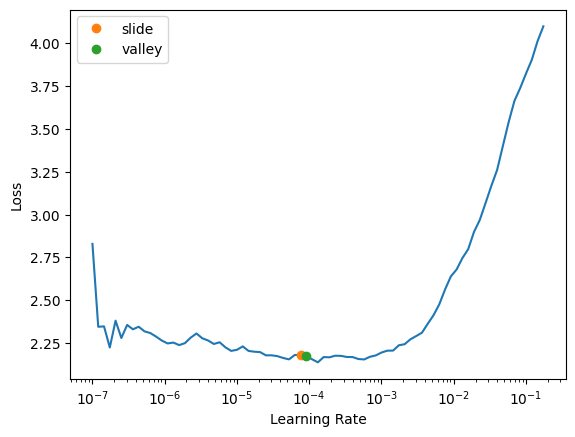

In [65]:
learn.lr_find(suggest_funcs=(slide, valley))

In [51]:
trn_path = path / 'train_images'

In [52]:
learn = train_mult('convnext_small_in22k',
                  item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  batch=aug_transforms(size=128, min_scale=0.75),
                  epochs=18)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.335374,1.119459,0.238347,0.127823,0.730059,0.389399,00:18


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.007303,0.549659,0.123018,0.051418,0.393449,0.156210,00:23
1,0.727374,0.394368,0.088900,0.028832,0.301171,0.093196,00:23
2,0.602785,0.359681,0.080730,0.032677,0.253762,0.105919,00:23
3,0.548289,0.431808,0.093224,0.045651,0.299129,0.132680,00:23
4,0.452364,0.360945,0.088900,0.020183,0.304039,0.056906,00:23
5,0.375995,0.248001,0.065353,0.012013,0.207696,0.040306,00:23
6,0.301634,0.188373,0.054301,0.012975,0.154726,0.033647,00:23
7,0.272253,0.185927,0.049976,0.009130,0.162961,0.022967,00:23
8,0.212756,0.160976,0.037963,0.007208,0.143784,0.017192,00:23
9,0.191357,0.171094,0.038924,0.004805,0.153125,0.017970,00:23


In [53]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds[:, :10], targs[0])

TensorBase(0.0250)

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(480, method='squish'),
                                   batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [ ]:
idxs = avg_pr.argmax(dim=1)
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = dls.vocab[idxs]
ss.to_csv('subm.csv', index=False)

In [ ]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [ ]:
from kaggle import api
api.competition_submit_cli('subm.csv', 'big ensemble tta double vit', comp)

100%|██████████| 70.5k/70.5k [00:00<00:00, 78.8kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification